In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ttim import *

### Use observation times from Oude Korendijk

In [2]:
drawdown = np.loadtxt('data/oudekorendijk_h30.dat')
tobs = drawdown[:,0] / 60 / 24
robs = 30
Q = 788

### Generate data

In [3]:
ml = ModelMaq(kaq=60, z=(-18, -25), Saq=1e-4, tmin=1e-5, tmax=1)
w = Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=0)
ml.solve()
hobs = ml.head(robs, 0, tobs)[0]

self.neq  1
solution complete


### See if TTim can find aquifer parameters back
Note that the value of Saq0 is printed incorrectly to the screen in the fit report (`lmfit` will fix this hopefully in the near future - issue has be posted). The correct fitted value is printed below the fit report. 

In [4]:
cal = Calibrate(ml)
cal.set_parameter(name='kaq0', initial=10)
cal.set_parameter(name='Saq0', initial=1e-4)
cal.series(name='obs1', x=robs, y=0, layer=0, t=tobs, h=hobs)
cal.fit(report=False)
display(cal.parameters)

..............................


,initial,optimal,pmin,pmax,std,perc_std
kaq0,10,[60.00002572496658],None,None,6.326670e-05,[0.00010544446111035675]
Saq0,0.0001,[9.999987942655355e-05],None,None,3.596245e-10,[0.0003596249128573655]


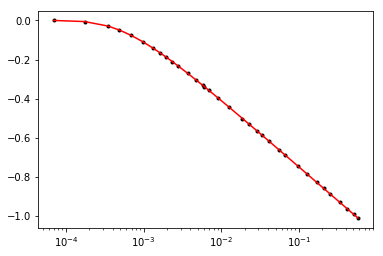

In [5]:
hm = ml.head(robs, 0, tobs, 0)
plt.semilogx(tobs, hobs, '.k')
plt.semilogx(tobs, hm[0], 'r')

In [6]:
print('correlation matrix')
print(cal.cormat)

correlation matrix
[[ 1.         -0.84973974]
 [-0.84973974  1.        ]]
